In [1]:
import theano
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Reshape
from keras.layers.convolutional import Conv1D, MaxPooling1D, ZeroPadding1D
from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU
from keras.optimizers import SGD
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pickle as pkl
import re

Using Theano backend.


In [2]:
feat_0_path='data/mon_exp/feat/0'
feat_1_path='data/mon_exp/feat/1'
#max_feat_count=7500

def get_feats(feat_0_path, feat_1_path, max_feat_count):
    feats_0_list = []
    for fil in os.listdir(feat_0_path):
        feats = []
        with open(os.path.join(feat_0_path, fil)) as f:
            feats = f.readlines()
            feats = [float(line) for line in feats]
        feats = np.array(feats)
        feats1 = np.zeros(max_feat_count)
        length = min(len(feats), max_feat_count)
        feats1[:length] = feats[:length]
        #print len(feats)
        feats_0_list.append(feats1)

    feats_1_list = []
    for fil in os.listdir(feat_1_path):
        feats = []
        with open(os.path.join(feat_1_path, fil)) as f:
            feats = f.readlines()
            feats = [float(line) for line in feats]
        feats = np.array(feats)
        feats1 = np.zeros(max_feat_count)
        length = min(len(feats), max_feat_count)
        feats1[:length] = feats[:length]
        #print len(feats1)
        feats_1_list.append(feats1)
    return feats_0_list, feats_1_list  

In [3]:
#num_test=100
def split(num_test, feats_0_list, feats_1_list):
    f0 = np.array(feats_0_list)
    f1 = np.array(feats_1_list)
    f1 = np.repeat(f1, 9, axis=0)
    print f0.shape
    print f1.shape
    f0_tr = f0[:-num_test, :]
    f1_tr = f1[:-num_test, :]
    print f0_tr.shape
    print f1_tr.shape
    f0_ts = f0[-num_test:, :]
    f1_ts = f1[-num_test:, :]
    print f0_ts.shape
    print f1_ts.shape
    return f0_tr, f1_tr, f0_ts, f1_ts

In [4]:
def append_labels(f0_tr, f1_tr, f0_ts, f1_ts):
    lab_0_tr = np.zeros((f0_tr.shape[0],1))
    lab_1_tr = np.zeros((f1_tr.shape[0],1))
    lab_0_ts = np.zeros((f0_ts.shape[0],1))
    lab_1_ts = np.zeros((f1_ts.shape[0],1))

    #lab_0_tr[:,0] = 1
    lab_1_tr[:,0] = 1
    #lab_0_ts[:,0] = 1
    lab_1_ts[:,0] = 1

    print lab_0_tr.shape
    x_0_tr = np.append(f0_tr,lab_0_tr, axis=1)
    x_1_tr = np.append(f1_tr, lab_1_tr, axis=1)
    print x_0_tr.shape
    x_0_ts = np.append(f0_ts, lab_0_ts, axis=1)
    x_1_ts = np.append(f1_ts, lab_1_ts, axis=1)
    return x_0_tr, lab_0_tr, x_1_tr, lab_1_tr, x_0_ts, lab_0_ts, x_1_ts, lab_1_ts

In [5]:
def get_shuffled( max_feat_count, x_0_tr, lab_0_tr, x_1_tr, lab_1_tr, x_0_ts, lab_0_ts, x_1_ts, lab_1_ts):
    x_tr = np.vstack([x_0_tr, x_1_tr])
    print x_tr.shape
    x_ts = np.vstack([x_0_ts, x_1_ts])
    np.random.shuffle(x_tr)
    np.random.shuffle(x_ts)
    X_tr = x_tr[:, 0:max_feat_count]
    y_tr = x_tr[:, max_feat_count:]
    X_ts = x_ts[:, 0:max_feat_count]
    y_ts = x_ts[:, max_feat_count:]
    print X_tr.shape
    print y_tr.shape
    print X_ts.shape
    print y_ts.shape
    return X_tr, y_tr, X_ts, y_ts

In [6]:
def ConvNet(max_len, weights_path=None):
    model = Sequential()
    model.add(Conv1D(4, (2,), activation='elu', input_shape=(max_len,1)))
    model.add(Conv1D(8, (2, ), activation='elu'))
    model.add(Conv1D(16, (2, ), activation='elu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(32, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))    
    
    if weights_path:
        model.load_weights(weights_path)

    return model


In [7]:
def VGG_16(max_len, weights_path=None):
    model = Sequential()
    model.add(ZeroPadding1D((1,1),input_shape=(1,max_len)))
    model.add(Conv1D(256, (3, ), activation='elu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(256, (3, ), activation='elu'))
    #model.add(MaxPooling2D((2,2), strides=(2,2)))
    print model.output_shape
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(128, (3, ), activation='elu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(128, (3, ), activation='elu'))
    print "Before max pool %s" %str(model.output_shape)
    model.add(MaxPooling1D(1))
    print model.output_shape
    #model.add(Reshape((128,)))
    print model.output_shape
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(64, (3, ), activation='elu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(64, (3, ), activation='elu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(64, (3, ), activation='elu'))
    #print model.output_shape
    model.add(MaxPooling1D(1))
    #model.add(Reshape(target_shape=(1,64)))
    #print model.output_shape
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(32, (3, ), activation='elu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(32, (3, ), activation='elu'))
    model.add(ZeroPadding1D((1,1)))
    model.add(Conv1D(32, (3, ), activation='elu'))
    model.add(MaxPooling1D(1))
    #model.add(Reshape(target_shape=(1,32)))
    #print model.output_shape
    '''
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    '''
    model.add(Flatten())
    model.add(Dense(32, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    '''model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='relu'))
    model.add(Dropout(0.5))'''
    
    
    if weights_path:
        model.load_weights(weights_path)

    return model


In [20]:
print theano.__version__
import keras.backend as K
K.set_image_dim_ordering('th')
print K.image_dim_ordering()
#input_shape=(1,max_feat_count)
#print all(input_shape[1:])
from theano import ifelse
print theano.ifelse.ifelse

0.10.0dev1.dev-d51233517debf3a1231a33058d65e8f969db923d
th
<function ifelse at 0x7f5c2f821140>


In [63]:
def get_model(max_feat_count, vgg = False):
    if not vgg:
        model = Sequential()        
        model.add(Dense(2, input_dim=max_feat_count, activation='elu'))
        model.add(Dense(1, activation='sigmoid' ))
    else:
        model = ConvNet(max_feat_count)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']  )
    return model

In [10]:
def reshape(X_tr, X_ts, vgg = False):
    if vgg:
        X_tr = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
        X_ts = X_ts.reshape(X_ts.shape[0], X_ts.shape[1], 1)
    return X_tr, X_ts

In [11]:
def train_model(model, X_tr, y_tr, batch_siz=32, epoch=10):
    return model.fit(X_tr, y_tr, batch_size=batch_siz, epochs=epoch)

In [12]:
def test_model(model, X_ts, y_ts):
    return model.evaluate(X_ts, y_ts, batch_size=X_ts.shape[0])

In [13]:
'''print X_tr.shape
print y_tr.shape
print model.summary()'''

'print X_tr.shape\nprint y_tr.shape\nprint model.summary()'

In [65]:
def run(feat_0_path, feat_1_path, max_feat_count, num_test, vgg, batch_size, epochs, per_epoch):
    X_tr, y_tr, X_ts, y_ts = get_shuffled( max_feat_count, *append_labels( *split( num_test, \
                                                        *get_feats(feat_0_path, feat_1_path, max_feat_count) ) ) )
    X_tr, X_ts = reshape(X_tr, X_ts, vgg)
    model = get_model(max_feat_count, vgg)
    ep  = 1 if per_epoch else epochs
    if per_epoch:
        print('%d more epochs to go'%epochs)
    
    h_tr = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=ep)
    l_tr = h_tr.history['loss'][-1]
    a_tr = h_tr.history['acc'][-1]
    print l_tr
    print a_tr
    h_ts = model.evaluate(f1.reshape(f1.shape[0], f1.shape[1]), lab_1_tr, batch_size=32)
    l_ts = h_ts[0]
    a_ts = h_ts[1]
    print l_ts
    print a_ts
    print model.predict(X_ts)
    mname = 'model_%s_%s_%s_%s_%s_%s_%s.h5'%(start_feat, end_feat, step_feat, vgg, batch_size, (11 - epochs), per_epoch)
    #model.save_weights(mname)
    if per_epoch:
        if epochs > 1:
            newl_tr, newa_tr, newl_ts, newa_ts = run(feat_0_path, feat_1_path, max_feat_count, num_test, vgg, batch_size, epochs-1, per_epoch)
            l_tr = [l_tr] + newl_tr; a_tr = [a_tr] + newa_tr
            l_ts = [l_ts] + newl_ts; a_ts = [a_ts] + newa_ts
        else:
            l_tr = [l_tr]; a_tr = [a_tr]; 
            l_ts = [l_ts]; a_ts = [a_ts]
    return l_tr, a_tr, l_ts, a_ts

In [66]:
def batch(feat_0_path, feat_1_path, num_test, start_feat, end_feat, step_feat=100, vgg=False, batch_size=32, epochs=2, per_epoch=False):
    tr_loss = []; tr_acc = []; ts_loss = []; ts_acc = []
    for feat in xrange(start_feat, end_feat, step_feat):
        print "Starting run - max_feat_count = %d"%feat
        l_tr, a_tr, l_ts, a_ts = run(feat_0_path, feat_1_path, feat, num_test, vgg, batch_size, epochs, per_epoch)
        tr_loss.append(l_tr)
        tr_acc.append(a_tr)
        ts_loss.append(l_ts)
        ts_acc.append(a_ts)
    return tr_loss, tr_acc, ts_loss, ts_acc    

In [67]:
feat_0_path='data/mon_exp/feat/0'
feat_1_path='data/mon_exp/feat/1'
num_test=100
start_feat = 4000
end_feat = 4400
step_feat = 500
vgg = False
batch_size=32
epochs=2
per_epoch=True
tr_loss, tr_acc, ts_loss, ts_acc = batch(feat_0_path, feat_1_path, num_test, start_feat, end_feat, step_feat, vgg, batch_size, epochs, per_epoch)

Starting run - max_feat_count = 4000
(2815, 4000)
(2880, 4000)
(2715, 4000)
(2780, 4000)
(100, 4000)
(100, 4000)
(2715, 1)
(2715, 4001)
(5495, 4001)
(5495, 4000)
(5495, 1)
(200, 4000)
(200, 1)
2 more epochs to go
Epoch 1/1
5495/5495 [==============================] - 0s - loss: 0.5720 - acc: 0.7316     
0.572007980562
0.731574158326
 32/800 [>.............................] - ETA: 0s0.306486530915
0.78625
[[ 0.42809188]
 [ 0.4678128 ]
 [ 0.50653807]
 [ 0.85758231]
 [ 0.30125716]
 [ 0.86469846]
 [ 0.4678128 ]
 [ 0.4678128 ]
 [ 0.42809188]
 [ 0.30288509]
 [ 0.30213803]
 [ 0.47094407]
 [ 0.85758231]
 [ 0.38265245]
 [ 0.48040701]
 [ 0.47366335]
 [ 0.47094407]
 [ 0.88065976]
 [ 0.41076605]
 [ 0.86469846]
 [ 0.42809188]
 [ 0.45283915]
 [ 0.88065976]
 [ 0.29691748]
 [ 0.4716286 ]
 [ 0.33118325]
 [ 0.49053544]
 [ 0.53864312]
 [ 0.89249062]
 [ 0.29732613]
 [ 0.29771816]
 [ 0.29703005]
 [ 0.42809188]
 [ 0.4786953 ]
 [ 0.49102375]
 [ 0.45494396]
 [ 0.40506613]
 [ 0.49053544]
 [ 0.31588552]
 [ 0.47

In [27]:
save_dict = {'tr_loss': tr_loss, 'tr_acc': tr_acc, 'ts_loss' : ts_loss, 'ts_acc' : ts_acc }
print save_dict
#pkl_file_name = 'results_%s_%s_%s_%s_%s_%s_%s.pkl'%(start_feat, end_feat, step_feat, vgg, batch_size, epochs, per_epoch)
#with open( pkl_file_name, 'wb') as f:
#    pkl.dump(save_dict, f)

{'ts_acc': [[0.71999999999999997, 0.75, 0.67500000000000004, 0.70999999999999996, 0.67500000000000004, 0.69999999999999996, 0.70999999999999996, 0.71499999999999997, 0.69999999999999996, 0.73499999999999999]], 'ts_loss': [[0.50603639380262422, 0.49173667666847259, 0.46116929798005857, 0.4898580206040023, 0.65839980387147934, 0.49533206867419083, 0.53581378117788558, 0.50223186709822643, 0.48439896163066032, 0.48261479032114268]], 'tr_acc': [[0.7368516833484986, 0.72811646951774345, 0.75195632393084622, 0.73393994540491359, 0.75341219290263872, 0.75741583257506828, 0.7481346678798908, 0.74103730664240219, 0.74686078252957233, 0.75031847133757967]], 'tr_loss': [[0.47427689454714411, 0.49836697689213483, 0.45998208545754554, 0.49270960169131112, 0.46913716971030889, 0.46368885134729843, 0.46175117200780913, 0.4894018141653908, 0.47039101429493457, 0.46903373025949291]]}


In [17]:
sd = {}
pkl_file_name = 'results/multitab_alexa_3/mta_20172408020937_500_10500_500_True_32_20_True/mta_20172408020937_500_10500_500_True_32_20_True.pkl'
with open(pkl_file_name, 'rb') as f:
    sd = pkl.load(f)
print sd    

{'tr_loss': [[1.6185381570382866, 1.6038808051235287, 1.6057639475793011, 1.5944144602458341, 1.6200150962245117, 1.6266995341968158, 1.6164036481662913, 1.6059489653508896, 1.605877027488573, 1.6003687155824382, 1.59282697408564, 1.6042420303519378, 1.607731669169908, 1.619122202097496, 1.6225905499595632, 1.6143772101315943, 1.5824276962286852, 1.5974675569272818, 1.6049703504940953, 1.6058494711686957], [1.577235717715056, 1.5942868854202348, 1.5499835706904215, 1.6115800804013856, 1.5894150321576941, 1.5603247409772207, 1.5553743729284661, 1.5906848694912668, 1.5830410301202247, 1.5959928057731936, 1.569511704967852, 1.6046405092439358, 1.5968092047442526, 1.5891520345924353, 1.5963389752219106, 1.5974873663906723, 1.6158486464492698, 1.6029590125494237, 1.5892645422806717, 1.6241885086322041], [1.5424798173541796, 1.5624709947805278, 1.5421449991521556, 1.5800296269032148, 1.5438193801683195, 1.5644766858043826, 1.5442331190005647, 1.5398657991056053, 1.5663677511553986, 1.5606812

In [21]:
print "Epoch wise max acc for all features"
print np.max(ts_acc, axis=1)
print "Feature wise max acc for all epochs"
print np.max(ts_acc, axis=0)
print "Epoch wise mean acc for all features"
print np.mean(ts_acc, axis=1)
print "Feature wise mean acc for all epochs"
print np.mean(ts_acc, axis=0)

print "Max avg accuracy across epochs"
print np.max(np.mean(ts_acc, axis=0))
print "Packet Count limit for which the accuracy achieved"
print 500*(np.argmax(np.mean(ts_acc, axis=0)) + 1)
print "Min avg loss across epochs"
print np.min(np.mean(ts_loss, axis=0))
print "Packet Count limit for which the min loss achieved"
print 500*(np.argmin(np.mean(ts_loss, axis=0)) + 1)
#print tr_acc[np.argmax(ts_acc)]

Epoch wise max acc for all features
[ 0.83000004  0.79500002  0.80500001  0.80499995  0.815       0.79499996
  0.815       0.84499997  0.80000001  0.80499995  0.83999991  0.815
  0.78999996  0.78000003  0.78500003  0.81999999  0.78499997  0.79999995
  0.82999992  0.79499996]
Feature wise max acc for all epochs
[ 0.53499997  0.62499994  0.58999991  0.73499995  0.68000001  0.78000003
  0.73499995  0.74999994  0.80500001  0.80000001  0.77999997  0.84499997
  0.80499995  0.83999991  0.79999995  0.815       0.83000004  0.815
  0.80499995  0.81999999]
Epoch wise mean acc for all features
[ 0.67624999  0.67649998  0.67574998  0.66474998  0.65799999  0.66974998
  0.66724998  0.68924999  0.67799998  0.66599998  0.68874998  0.68624999
  0.67425     0.64524997  0.68099998  0.67349999  0.64774998  0.67874999
  0.67949999  0.67724998]
Feature wise mean acc for all epochs
[ 0.50749998  0.52724998  0.54349996  0.60574997  0.61824999  0.65449998
  0.65024999  0.64949997  0.70875     0.71974998  0.6779

(20,)


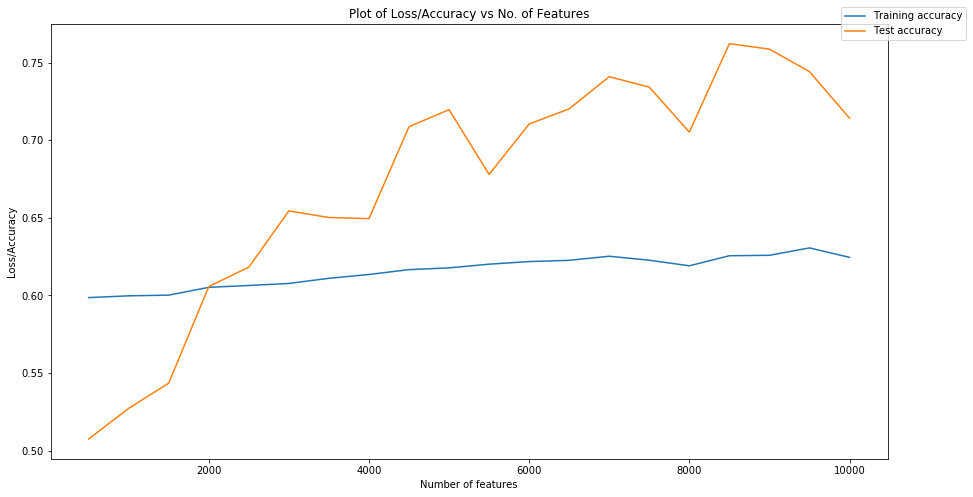

In [20]:
plt.rcParams['figure.figsize'] = (15, 8)

#f = np.arange(start_feat, end_feat, step_feat)
f = np.arange(500, 10500, 500)
tr_avg_loss = np.mean(tr_loss, axis = 0)
tr_avg_acc =  np.mean(tr_acc, axis = 0)
ts_avg_loss = np.mean(ts_loss, axis = 0)
ts_avg_acc =  np.mean(ts_acc, axis = 0)
print tr_avg_loss.shape
#plt.subplot(221)
#plt.plot(f, tr_avg_loss, label='Training Loss')

#plt.subplot(222)
plt.plot(f, tr_avg_acc, label='Training accuracy')

#plt.subplot(223)
#plt.plot(f, ts_avg_loss, label='Test Loss')

#plt.subplot(224)
plt.plot(f, ts_avg_acc, label='Test accuracy')

plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.xlabel("Number of features")
plt.ylabel("Loss/Accuracy")
plt.title("Plot of Loss/Accuracy vs No. of Features")

plt.show()

In [61]:
X_tr, y_tr, X_ts, y_ts = get_shuffled( 4000, *append_labels( *split( 100, \
                                                        *get_feats(feat_0_path, feat_1_path, 4000) ) ) )
X_tr, X_ts = reshape(X_tr, X_ts, True)
tr_loss = []; tr_acc = []; ts_loss = []; ts_acc = []
model = get_model(4000, True)
for i in range(50):
    h_tr = model.fit(X_tr, y_tr, batch_size=32, epochs=1)
    l_tr = h_tr.history['loss'][-1]
    a_tr = h_tr.history['acc'][-1]
    print l_tr
    print a_tr
    h_ts = model.evaluate(X_ts, y_ts, batch_size=X_ts.shape[0])
    l_ts = h_ts[0]
    a_ts = h_ts[1]
    print l_ts
    print a_ts
    tr_loss.append(l_tr)
    tr_acc.append(a_tr)
    ts_loss.append(l_ts)
    ts_acc.append(a_ts)
    print model.predict(X_ts[0:200])

(2815, 4000)
(2880, 4000)
(2715, 4000)
(2780, 4000)
(100, 4000)
(100, 4000)
(2715, 2)
(2715, 4002)
(5495, 4002)
(5495, 4000)
(5495, 2)
(200, 4000)
(200, 2)
(None, 1, 256)
Before max pool (None, 1, 128)
(None, 1, 128)
(None, 1, 128)
Epoch 1/1
5495/5495 [==============================] - 63s - loss: 0.6939 - acc: 0.5050    
0.693893783481
0.505004549591
200/200 [==============================] - 1s
0.693169252243
0.5
[[ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801  0.50332199]
 [ 0.49667801 

5495/5495 [==============================] - 63s - loss: 0.5628 - acc: 0.7350    
0.562843273088
0.735031847134
200/200 [==============================] - 1s
0.563641482779
0.675
[[ 0.52479381  0.47520619]
 [ 0.1399566   0.8600434 ]
 [ 0.62917931  0.37082069]
 [ 0.43213492  0.56786508]
 [ 0.76292768  0.23707232]
 [ 0.76080135  0.23919865]
 [ 0.3493353   0.6506647 ]
 [ 0.76838052  0.23161948]
 [ 0.43213492  0.56786508]
 [ 0.14581306  0.85418694]
 [ 0.1388238   0.8611762 ]
 [ 0.1399566   0.8600434 ]
 [ 0.76080135  0.23919865]
 [ 0.78626197  0.21373803]
 [ 0.68647123  0.31352877]
 [ 0.43213492  0.56786508]
 [ 0.19420326  0.80579674]
 [ 0.76838052  0.23161948]
 [ 0.1347052   0.8652948 ]
 [ 0.41530252  0.58469748]
 [ 0.62917931  0.37082069]
 [ 0.9867503   0.0132497 ]
 [ 0.36922953  0.63077047]
 [ 0.62917931  0.37082069]
 [ 0.62917931  0.37082069]
 [ 0.88463728  0.11536272]
 [ 0.72675106  0.27324894]
 [ 0.79445979  0.20554021]
 [ 0.72675106  0.27324894]
 [ 0.75281708  0.24718292]
 [ 0.702130

5495/5495 [==============================] - 63s - loss: 0.3738 - acc: 0.8331    
0.373797093888
0.833121019108
200/200 [==============================] - 1s
0.6842065277
0.71
[[  9.99999047e-01   9.52769962e-07]
 [  3.87511452e-02   9.61248855e-01]
 [  7.79062149e-01   2.20937851e-01]
 [  1.43850950e-01   8.56149050e-01]
 [  5.80083163e-01   4.19916837e-01]
 [  6.56739125e-01   3.43260875e-01]
 [  9.69745018e-01   3.02549819e-02]
 [  6.71138796e-01   3.28861204e-01]
 [  1.43850950e-01   8.56149050e-01]
 [  4.46483513e-02   9.55351649e-01]
 [  4.56988082e-02   9.54301192e-01]
 [  3.87511452e-02   9.61248855e-01]
 [  6.56739125e-01   3.43260875e-01]
 [  9.52903618e-01   4.70963820e-02]
 [  8.35005002e-01   1.64994998e-01]
 [  1.43850950e-01   8.56149050e-01]
 [  6.72975306e-02   9.32702469e-01]
 [  6.71138796e-01   3.28861204e-01]
 [  3.77980160e-02   9.62201984e-01]
 [  6.53001499e-01   3.46998501e-01]
 [  7.79062149e-01   2.20937851e-01]
 [  9.99999700e-01   2.99732760e-07]
 [  2.5041

5495/5495 [==============================] - 64s - loss: 0.3365 - acc: 0.8379    
0.336494138451
0.837852593267
200/200 [==============================] - 1s
0.420627875939
0.73
[[  9.99999999e-01   1.14806787e-09]
 [  6.26418502e-03   9.93735815e-01]
 [  5.36353430e-01   4.63646570e-01]
 [  1.25469503e-01   8.74530497e-01]
 [  5.39107324e-01   4.60892676e-01]
 [  5.22072699e-01   4.77927301e-01]
 [  1.04931034e-01   8.95068966e-01]
 [  5.61689561e-01   4.38310439e-01]
 [  1.25469503e-01   8.74530497e-01]
 [  1.01978909e-02   9.89802109e-01]
 [  1.00718674e-02   9.89928133e-01]
 [  6.26418502e-03   9.93735815e-01]
 [  5.22072699e-01   4.77927301e-01]
 [  5.85308234e-01   4.14691766e-01]
 [  9.62832108e-01   3.71678919e-02]
 [  1.25469503e-01   8.74530497e-01]
 [  3.62350113e-02   9.63764989e-01]
 [  5.61689561e-01   4.38310439e-01]
 [  6.48276559e-03   9.93517234e-01]
 [  7.89156182e-01   2.10843818e-01]
 [  5.36353430e-01   4.63646570e-01]
 [  9.99999994e-01   6.36516989e-09]
 [  1.03

5495/5495 [==============================] - 65s - loss: 0.3172 - acc: 0.8460    
0.317173431926
0.846041856233
200/200 [==============================] - 1s
0.408399803831
0.725
[[  9.99999995e-01   4.98701075e-09]
 [  4.61523207e-02   9.53847679e-01]
 [  6.36469440e-01   3.63530560e-01]
 [  1.80239255e-01   8.19760745e-01]
 [  9.29855499e-01   7.01445008e-02]
 [  6.30507431e-01   3.69492569e-01]
 [  2.96736863e-01   7.03263137e-01]
 [  8.98034384e-01   1.01965616e-01]
 [  1.80239255e-01   8.19760745e-01]
 [  7.15304620e-02   9.28469538e-01]
 [  8.59713518e-02   9.14028648e-01]
 [  4.61523207e-02   9.53847679e-01]
 [  6.30507431e-01   3.69492569e-01]
 [  7.34870301e-01   2.65129699e-01]
 [  9.34198011e-01   6.58019894e-02]
 [  1.80239255e-01   8.19760745e-01]
 [  7.62030970e-02   9.23796903e-01]
 [  8.98034384e-01   1.01965616e-01]
 [  3.03941832e-02   9.69605817e-01]
 [  4.14502044e-01   5.85497956e-01]
 [  6.36469440e-01   3.63530560e-01]
 [  9.99999922e-01   7.80376290e-08]
 [  2.6

5495/5495 [==============================] - 63s - loss: 0.3093 - acc: 0.8488    
0.309319173747
0.848771610555
200/200 [==============================] - 1s
0.401881825208
0.73
[[  9.99999993e-01   6.79803205e-09]
 [  2.98965507e-02   9.70103449e-01]
 [  5.74240313e-01   4.25759687e-01]
 [  1.09458454e-01   8.90541546e-01]
 [  5.83652649e-01   4.16347351e-01]
 [  5.67882416e-01   4.32117584e-01]
 [  1.90045071e-01   8.09954929e-01]
 [  9.31637982e-01   6.83620183e-02]
 [  1.09458454e-01   8.90541546e-01]
 [  3.31231584e-02   9.66876842e-01]
 [  9.62172453e-02   9.03782755e-01]
 [  2.98965507e-02   9.70103449e-01]
 [  5.67882416e-01   4.32117584e-01]
 [  7.24459929e-01   2.75540071e-01]
 [  9.93816987e-01   6.18301253e-03]
 [  1.09458454e-01   8.90541546e-01]
 [  4.73691956e-02   9.52630804e-01]
 [  9.31637982e-01   6.83620183e-02]
 [  3.18259008e-02   9.68174099e-01]
 [  1.80428454e-01   8.19571546e-01]
 [  5.74240313e-01   4.25759687e-01]
 [  1.00000000e+00   1.74425678e-10]
 [  1.53

5495/5495 [==============================] - 64s - loss: 0.2898 - acc: 0.8497    
0.289810314858
0.849681528662
200/200 [==============================] - 1s
0.557347484525
0.695
[[  8.31240459e-03   9.91687595e-01]
 [  2.05671045e-02   9.79432895e-01]
 [  5.60658005e-01   4.39341995e-01]
 [  5.80416506e-02   9.41958349e-01]
 [  5.60257878e-01   4.39742122e-01]
 [  5.63271342e-01   4.36728658e-01]
 [  8.65229586e-02   9.13477041e-01]
 [  5.55256504e-01   4.44743496e-01]
 [  5.80416506e-02   9.41958349e-01]
 [  2.99399960e-02   9.70060004e-01]
 [  5.48241368e-01   4.51758632e-01]
 [  2.05671045e-02   9.79432895e-01]
 [  5.63271342e-01   4.36728658e-01]
 [  5.53920792e-01   4.46079208e-01]
 [  9.64517459e-01   3.54825411e-02]
 [  5.80416506e-02   9.41958349e-01]
 [  2.22131646e-02   9.77786835e-01]
 [  5.55256504e-01   4.44743496e-01]
 [  1.87280002e-02   9.81272000e-01]
 [  1.47957005e-01   8.52042995e-01]
 [  5.60658005e-01   4.39341995e-01]
 [  9.99999211e-01   7.89220168e-07]
 [  1.0

5495/5495 [==============================] - 63s - loss: 0.2772 - acc: 0.8559    
0.277170523016
0.855868971793
200/200 [==============================] - 1s
0.461728056579
0.775
[[  9.99999999e-01   5.39354134e-10]
 [  2.42963073e-03   9.97570369e-01]
 [  5.85827923e-01   4.14172077e-01]
 [  1.51095318e-02   9.84890468e-01]
 [  9.33394222e-01   6.66057776e-02]
 [  5.94180598e-01   4.05819402e-01]
 [  6.54046218e-02   9.34595378e-01]
 [  9.92843575e-01   7.15642497e-03]
 [  1.51095318e-02   9.84890468e-01]
 [  3.82967446e-03   9.96170326e-01]
 [  5.47420315e-01   4.52579685e-01]
 [  2.42963073e-03   9.97570369e-01]
 [  5.94180598e-01   4.05819402e-01]
 [  5.09648152e-01   4.90351848e-01]
 [  9.99385930e-01   6.14070077e-04]
 [  1.51095318e-02   9.84890468e-01]
 [  1.59758983e-03   9.98402410e-01]
 [  9.92843575e-01   7.15642497e-03]
 [  1.20534677e-03   9.98794653e-01]
 [  3.43812226e-02   9.65618777e-01]
 [  5.85827923e-01   4.14172077e-01]
 [  1.00000000e+00   1.07265895e-11]
 [  2.4

5495/5495 [==============================] - 64s - loss: 0.2642 - acc: 0.8648    
0.264230561253
0.864786169245
200/200 [==============================] - 1s
0.65615122185
0.705
[[  9.69699142e-01   3.03008579e-02]
 [  4.76970593e-03   9.95230294e-01]
 [  5.71459061e-01   4.28540939e-01]
 [  3.07788143e-02   9.69221186e-01]
 [  8.95132504e-01   1.04867496e-01]
 [  6.09152408e-01   3.90847592e-01]
 [  7.14626938e-01   2.85373062e-01]
 [  9.64772334e-01   3.52276659e-02]
 [  3.07788143e-02   9.69221186e-01]
 [  8.23055497e-04   9.99176945e-01]
 [  3.24238071e-02   9.67576193e-01]
 [  4.76970593e-03   9.95230294e-01]
 [  6.09152408e-01   3.90847592e-01]
 [  3.17896763e-01   6.82103237e-01]
 [  9.98131674e-01   1.86832574e-03]
 [  3.07788143e-02   9.69221186e-01]
 [  7.75082335e-04   9.99224918e-01]
 [  9.64772334e-01   3.52276659e-02]
 [  1.08753624e-03   9.98912464e-01]
 [  6.49004307e-02   9.35099569e-01]
 [  5.71459061e-01   4.28540939e-01]
 [  1.00000000e+00   4.47808479e-10]
 [  6.46

5495/5495 [==============================] - 64s - loss: 0.2595 - acc: 0.8677    
0.259473902855
0.867697907188
200/200 [==============================] - 1s
0.409700032945
0.71
[[  1.00000000e+00   2.15682726e-12]
 [  1.37576594e-01   8.62423406e-01]
 [  5.60073494e-01   4.39926506e-01]
 [  2.39011280e-01   7.60988720e-01]
 [  4.83136314e-01   5.16863686e-01]
 [  5.84418152e-01   4.15581848e-01]
 [  7.82205233e-01   2.17794767e-01]
 [  4.99761134e-01   5.00238866e-01]
 [  2.39011280e-01   7.60988720e-01]
 [  1.61922774e-02   9.83807723e-01]
 [  1.81711587e-01   8.18288413e-01]
 [  1.37576594e-01   8.62423406e-01]
 [  5.84418152e-01   4.15581848e-01]
 [  4.63743682e-01   5.36256318e-01]
 [  9.77176316e-01   2.28236844e-02]
 [  2.39011280e-01   7.60988720e-01]
 [  1.89603592e-02   9.81039641e-01]
 [  4.99761134e-01   5.00238866e-01]
 [  5.32743967e-02   9.46725603e-01]
 [  2.81895885e-01   7.18104115e-01]
 [  5.60073494e-01   4.39926506e-01]
 [  9.99999998e-01   2.08260860e-09]
 [  2.64

5495/5495 [==============================] - 63s - loss: 0.2495 - acc: 0.8788    
0.249501956654
0.878798908098
200/200 [==============================] - 1s
0.561872500147
0.745
[[  1.00000000e+00   9.05146451e-24]
 [  1.03520678e-01   8.96479322e-01]
 [  5.90522310e-01   4.09477690e-01]
 [  1.44414143e-01   8.55585857e-01]
 [  3.21354549e-01   6.78645451e-01]
 [  6.70107390e-01   3.29892610e-01]
 [  9.84875830e-01   1.51241699e-02]
 [  3.42896977e-01   6.57103023e-01]
 [  1.44414143e-01   8.55585857e-01]
 [  4.55575060e-02   9.54442494e-01]
 [  5.85598551e-02   9.41440145e-01]
 [  1.03520678e-01   8.96479322e-01]
 [  6.70107390e-01   3.29892610e-01]
 [  3.35718171e-01   6.64281829e-01]
 [  9.96264228e-01   3.73577173e-03]
 [  1.44414143e-01   8.55585857e-01]
 [  8.29831074e-02   9.17016893e-01]
 [  3.42896977e-01   6.57103023e-01]
 [  5.41863171e-02   9.45813683e-01]
 [  1.37226534e-01   8.62773466e-01]
 [  5.90522310e-01   4.09477690e-01]
 [  1.00000000e+00   4.49868233e-19]
 [  1.8

5495/5495 [==============================] - 63s - loss: 0.2349 - acc: 0.8875    
0.234894961365
0.887534121929
200/200 [==============================] - 1s
0.346098095852
0.81
[[  1.00000000e+00   2.49014411e-21]
 [  1.31904906e-01   8.68095094e-01]
 [  6.41749371e-01   3.58250629e-01]
 [  1.14467221e-01   8.85532779e-01]
 [  5.55990184e-01   4.44009816e-01]
 [  6.17384393e-01   3.82615607e-01]
 [  1.15739997e-01   8.84260003e-01]
 [  8.41741923e-01   1.58258077e-01]
 [  1.14467221e-01   8.85532779e-01]
 [  2.42528342e-02   9.75747166e-01]
 [  7.25008447e-03   9.92749916e-01]
 [  1.31904906e-01   8.68095094e-01]
 [  6.17384393e-01   3.82615607e-01]
 [  3.21705450e-01   6.78294550e-01]
 [  9.97552265e-01   2.44773543e-03]
 [  1.14467221e-01   8.85532779e-01]
 [  2.09481034e-02   9.79051897e-01]
 [  8.41741923e-01   1.58258077e-01]
 [  3.56881909e-02   9.64311809e-01]
 [  8.28620013e-02   9.17137999e-01]
 [  6.41749371e-01   3.58250629e-01]
 [  1.00000000e+00   2.07811128e-16]
 [  1.51

5495/5495 [==============================] - 64s - loss: 0.2375 - acc: 0.8830    
0.237500501396
0.882984531392
200/200 [==============================] - 1s
0.555903307867
0.76
[[  1.00000000e+00   5.49123885e-11]
 [  4.18217112e-01   5.81782888e-01]
 [  7.41065432e-01   2.58934568e-01]
 [  3.66164812e-01   6.33835188e-01]
 [  7.40262542e-01   2.59737458e-01]
 [  5.67212326e-01   4.32787674e-01]
 [  9.82977264e-01   1.70227360e-02]
 [  8.32166319e-01   1.67833681e-01]
 [  3.66164812e-01   6.33835188e-01]
 [  4.26337976e-03   9.95736620e-01]
 [  7.63811117e-03   9.92361889e-01]
 [  4.18217112e-01   5.81782888e-01]
 [  5.67212326e-01   4.32787674e-01]
 [  2.88184863e-01   7.11815137e-01]
 [  9.58406923e-01   4.15930767e-02]
 [  3.66164812e-01   6.33835188e-01]
 [  4.27436354e-02   9.57256365e-01]
 [  8.32166319e-01   1.67833681e-01]
 [  1.17807418e-01   8.82192582e-01]
 [  1.47537136e-01   8.52462864e-01]
 [  7.41065432e-01   2.58934568e-01]
 [  1.00000000e+00   4.07672066e-11]
 [  4.42

5495/5495 [==============================] - 64s - loss: 0.2268 - acc: 0.8839    
0.226849916369
0.8838944495
200/200 [==============================] - 1s
0.896393788623
0.74
[[  4.05989784e-02   9.59401022e-01]
 [  2.43859257e-01   7.56140743e-01]
 [  7.90914016e-01   2.09085984e-01]
 [  2.51318190e-01   7.48681810e-01]
 [  8.97717307e-01   1.02282693e-01]
 [  5.86077788e-01   4.13922212e-01]
 [  9.99869172e-01   1.30828019e-04]
 [  7.38071583e-01   2.61928417e-01]
 [  2.51318190e-01   7.48681810e-01]
 [  6.03572967e-04   9.99396427e-01]
 [  4.44825647e-04   9.99555174e-01]
 [  2.43859257e-01   7.56140743e-01]
 [  5.86077788e-01   4.13922212e-01]
 [  1.91619111e-01   8.08380889e-01]
 [  9.97165740e-01   2.83425970e-03]
 [  2.51318190e-01   7.48681810e-01]
 [  5.44891767e-03   9.94551082e-01]
 [  7.38071583e-01   2.61928417e-01]
 [  7.30216907e-02   9.26978309e-01]
 [  1.87885125e-01   8.12114875e-01]
 [  7.90914016e-01   2.09085984e-01]
 [  1.00000000e+00   2.99567325e-15]
 [  3.0797

5495/5495 [==============================] - 65s - loss: 0.2222 - acc: 0.8881    
0.222235630259
0.888080072793
200/200 [==============================] - 1s
0.514301417499
0.82
[[  1.00000000e+00   4.35595268e-13]
 [  8.20985164e-03   9.91790148e-01]
 [  7.84471605e-01   2.15528395e-01]
 [  1.06335250e-01   8.93664750e-01]
 [  9.40594542e-01   5.94054579e-02]
 [  4.72540647e-01   5.27459353e-01]
 [  9.69379844e-01   3.06201562e-02]
 [  8.80406583e-01   1.19593417e-01]
 [  1.06335250e-01   8.93664750e-01]
 [  4.76054711e-04   9.99523945e-01]
 [  1.23058360e-04   9.99876942e-01]
 [  8.20985164e-03   9.91790148e-01]
 [  4.72540647e-01   5.27459353e-01]
 [  1.84228637e-01   8.15771363e-01]
 [  9.83213813e-01   1.67861866e-02]
 [  1.06335250e-01   8.93664750e-01]
 [  1.00527939e-03   9.98994721e-01]
 [  8.80406583e-01   1.19593417e-01]
 [  3.76079407e-03   9.96239206e-01]
 [  1.44914561e-01   8.55085439e-01]
 [  7.84471605e-01   2.15528395e-01]
 [  1.00000000e+00   5.00724586e-11]
 [  1.58

5495/5495 [==============================] - 64s - loss: 0.2052 - acc: 0.8961    
0.205225307571
0.896087352138
200/200 [==============================] - 1s
0.725193404589
0.79
[[  1.00000000e+00   1.01190965e-18]
 [  3.13685126e-04   9.99686315e-01]
 [  8.39593987e-01   1.60406013e-01]
 [  6.63739982e-03   9.93362600e-01]
 [  9.94259902e-01   5.74009753e-03]
 [  6.16177526e-01   3.83822474e-01]
 [  9.99443116e-01   5.56884220e-04]
 [  9.41284083e-01   5.87159171e-02]
 [  6.63739982e-03   9.93362600e-01]
 [  9.24826914e-07   9.99999075e-01]
 [  7.62891218e-07   9.99999237e-01]
 [  3.13685126e-04   9.99686315e-01]
 [  6.16177526e-01   3.83822474e-01]
 [  3.29237004e-02   9.67076300e-01]
 [  9.99863912e-01   1.36087697e-04]
 [  6.63739982e-03   9.93362600e-01]
 [  6.40999310e-03   9.93590007e-01]
 [  9.41284083e-01   5.87159171e-02]
 [  2.08626247e-03   9.97913738e-01]
 [  2.52298301e-02   9.74770170e-01]
 [  8.39593987e-01   1.60406013e-01]
 [  1.00000000e+00   5.71074757e-16]
 [  1.87

5495/5495 [==============================] - 65s - loss: 0.1998 - acc: 0.8994    
0.199817284105
0.899363057325
200/200 [==============================] - 1s
0.615616484303
0.8
[[  1.00000000e+00   8.13096158e-12]
 [  2.05551506e-03   9.97944485e-01]
 [  8.81540175e-01   1.18459825e-01]
 [  1.15879758e-01   8.84120242e-01]
 [  9.78711471e-01   2.12885286e-02]
 [  4.60889394e-01   5.39110606e-01]
 [  9.63150579e-01   3.68494207e-02]
 [  7.02397792e-01   2.97602208e-01]
 [  1.15879758e-01   8.84120242e-01]
 [  1.38590389e-04   9.99861410e-01]
 [  1.41904544e-04   9.99858095e-01]
 [  2.05551506e-03   9.97944485e-01]
 [  4.60889394e-01   5.39110606e-01]
 [  6.13830599e-02   9.38616940e-01]
 [  9.97130984e-01   2.86901610e-03]
 [  1.15879758e-01   8.84120242e-01]
 [  9.67736768e-01   3.22632322e-02]
 [  7.02397792e-01   2.97602208e-01]
 [  8.06260964e-03   9.91937390e-01]
 [  6.05088814e-01   3.94911186e-01]
 [  8.81540175e-01   1.18459825e-01]
 [  1.00000000e+00   1.57829560e-13]
 [  4.075

5495/5495 [==============================] - 64s - loss: 0.1838 - acc: 0.9072    
0.183797763319
0.907188353048
200/200 [==============================] - 1s
1.45303249899
0.69
[[  9.99999761e-01   2.39346795e-07]
 [  6.65408070e-03   9.93345919e-01]
 [  9.47895923e-01   5.21040768e-02]
 [  9.98047178e-02   9.00195282e-01]
 [  9.99093628e-01   9.06371952e-04]
 [  6.09560664e-01   3.90439336e-01]
 [  9.99999934e-01   6.63987513e-08]
 [  8.63426427e-01   1.36573573e-01]
 [  9.98047178e-02   9.00195282e-01]
 [  8.17571493e-05   9.99918243e-01]
 [  2.04920346e-04   9.99795080e-01]
 [  6.65408070e-03   9.93345919e-01]
 [  6.09560664e-01   3.90439336e-01]
 [  3.47223312e-02   9.65277669e-01]
 [  9.99866104e-01   1.33896196e-04]
 [  9.98047178e-02   9.00195282e-01]
 [  9.92984624e-01   7.01537648e-03]
 [  8.63426427e-01   1.36573573e-01]
 [  9.89150503e-03   9.90108495e-01]
 [  4.09761526e-02   9.59023847e-01]
 [  9.47895923e-01   5.21040768e-02]
 [  1.00000000e+00   1.52184851e-22]
 [  1.073

5495/5495 [==============================] - 63s - loss: 0.1824 - acc: 0.9099    
0.182446886608
0.90991810737
200/200 [==============================] - 1s
1.05432642333
0.76
[[  9.87122616e-01   1.28773844e-02]
 [  3.09784951e-03   9.96902150e-01]
 [  8.29420833e-01   1.70579167e-01]
 [  8.07272506e-02   9.19272749e-01]
 [  9.99292749e-01   7.07251174e-04]
 [  4.63497340e-01   5.36502660e-01]
 [  9.99995573e-01   4.42672752e-06]
 [  9.53090046e-01   4.69099541e-02]
 [  8.07272506e-02   9.19272749e-01]
 [  7.39747659e-01   2.60252341e-01]
 [  2.53990208e-03   9.97460098e-01]
 [  3.09784951e-03   9.96902150e-01]
 [  4.63497340e-01   5.36502660e-01]
 [  8.27243737e-02   9.17275626e-01]
 [  9.99991288e-01   8.71234830e-06]
 [  8.07272506e-02   9.19272749e-01]
 [  1.87498691e-01   8.12501309e-01]
 [  9.53090046e-01   4.69099541e-02]
 [  2.83186026e-03   9.97168140e-01]
 [  4.22521277e-02   9.57747872e-01]
 [  8.29420833e-01   1.70579167e-01]
 [  1.00000000e+00   3.07287699e-24]
 [  3.3702

5495/5495 [==============================] - 64s - loss: 0.1707 - acc: 0.9136    
0.170684086924
0.9135577798
200/200 [==============================] - 1s
1.26386580925
0.75
[[  1.00000000e+00   3.01253649e-40]
 [  1.12650567e-04   9.99887349e-01]
 [  8.50948653e-01   1.49051347e-01]
 [  1.90799961e-02   9.80920004e-01]
 [  9.99918030e-01   8.19703116e-05]
 [  8.63944387e-01   1.36055613e-01]
 [  9.99999547e-01   4.52718089e-07]
 [  7.86064837e-01   2.13935163e-01]
 [  1.90799961e-02   9.80920004e-01]
 [  5.72497040e-06   9.99994275e-01]
 [  7.13495458e-07   9.99999287e-01]
 [  1.12650567e-04   9.99887349e-01]
 [  8.63944387e-01   1.36055613e-01]
 [  1.45488322e-02   9.85451168e-01]
 [  9.99959299e-01   4.07012046e-05]
 [  1.90799961e-02   9.80920004e-01]
 [  9.69435120e-01   3.05648801e-02]
 [  7.86064837e-01   2.13935163e-01]
 [  1.83317242e-03   9.98166828e-01]
 [  1.61839873e-02   9.83816013e-01]
 [  8.50948653e-01   1.49051347e-01]
 [  1.00000000e+00   2.20130130e-26]
 [  3.13065

5495/5495 [==============================] - 64s - loss: 0.1708 - acc: 0.9225    
0.170764225368
0.922474977252
200/200 [==============================] - 1s
1.23686573229
0.755
[[  1.00000000e+00   4.89633851e-23]
 [  5.78192833e-05   9.99942181e-01]
 [  9.32001212e-01   6.79987884e-02]
 [  3.80966192e-02   9.61903381e-01]
 [  9.98672496e-01   1.32750399e-03]
 [  9.45585319e-01   5.44146808e-02]
 [  9.99990486e-01   9.51448794e-06]
 [  7.18094809e-01   2.81905191e-01]
 [  3.80966192e-02   9.61903381e-01]
 [  1.16215459e-06   9.99998838e-01]
 [  3.59181878e-06   9.99996408e-01]
 [  5.78192833e-05   9.99942181e-01]
 [  9.45585319e-01   5.44146808e-02]
 [  8.66677687e-03   9.91333223e-01]
 [  9.99821956e-01   1.78043971e-04]
 [  3.80966192e-02   9.61903381e-01]
 [  9.93176676e-01   6.82332441e-03]
 [  7.18094809e-01   2.81905191e-01]
 [  3.22738621e-04   9.99677261e-01]
 [  3.71574699e-01   6.28425301e-01]
 [  9.32001212e-01   6.79987884e-02]
 [  1.00000000e+00   1.43306604e-17]
 [  4.76

5495/5495 [==============================] - 63s - loss: 0.1593 - acc: 0.9228    
0.159339588345
0.922838944495
200/200 [==============================] - 1s
1.22636707206
0.765
[[  1.00000000e+00   1.61220543e-21]
 [  7.35017423e-05   9.99926498e-01]
 [  8.64478918e-01   1.35521082e-01]
 [  2.08125631e-02   9.79187437e-01]
 [  9.99145686e-01   8.54313923e-04]
 [  3.36667599e-01   6.63332401e-01]
 [  9.99927343e-01   7.26573278e-05]
 [  8.48095078e-01   1.51904922e-01]
 [  2.08125631e-02   9.79187437e-01]
 [  6.06516786e-08   9.99999939e-01]
 [  6.70311525e-07   9.99999330e-01]
 [  7.35017423e-05   9.99926498e-01]
 [  3.36667599e-01   6.63332401e-01]
 [  1.00930296e-01   8.99069704e-01]
 [  9.89834912e-01   1.01650880e-02]
 [  2.08125631e-02   9.79187437e-01]
 [  9.90475459e-01   9.52454114e-03]
 [  8.48095078e-01   1.51904922e-01]
 [  2.05921684e-03   9.97940783e-01]
 [  5.90443091e-03   9.94095569e-01]
 [  8.64478918e-01   1.35521082e-01]
 [  1.00000000e+00   2.81741761e-18]
 [  4.72

5495/5495 [==============================] - 62s - loss: 0.1583 - acc: 0.9259    
0.158276134199
0.92593266606
200/200 [==============================] - 1s
0.986373631589
0.745
[[  1.00000000e+00   7.77526204e-20]
 [  3.66026625e-04   9.99633973e-01]
 [  9.82278020e-01   1.77219803e-02]
 [  2.05741982e-02   9.79425802e-01]
 [  9.97331135e-01   2.66886478e-03]
 [  2.67933761e-01   7.32066239e-01]
 [  9.99940457e-01   5.95428758e-05]
 [  6.52842203e-01   3.47157797e-01]
 [  2.05741982e-02   9.79425802e-01]
 [  8.24219357e-06   9.99991758e-01]
 [  1.20605963e-04   9.99879394e-01]
 [  3.66026625e-04   9.99633973e-01]
 [  2.67933761e-01   7.32066239e-01]
 [  8.09932938e-02   9.19006706e-01]
 [  9.92401915e-01   7.59808525e-03]
 [  2.05741982e-02   9.79425802e-01]
 [  6.43662097e-01   3.56337903e-01]
 [  6.52842203e-01   3.47157797e-01]
 [  1.32906845e-03   9.98670932e-01]
 [  6.66735807e-01   3.33264193e-01]
 [  9.82278020e-01   1.77219803e-02]
 [  1.00000000e+00   3.73097076e-16]
 [  2.20

5495/5495 [==============================] - 63s - loss: 0.1536 - acc: 0.9259    
0.153570943244
0.92593266606
200/200 [==============================] - 1s
0.976059129827
0.75
[[  1.00000000e+00   2.26739454e-37]
 [  1.11145598e-05   9.99988885e-01]
 [  8.99487400e-01   1.00512600e-01]
 [  5.28578617e-03   9.94714214e-01]
 [  9.99821664e-01   1.78336369e-04]
 [  3.94385118e-01   6.05614882e-01]
 [  9.95283821e-01   4.71617895e-03]
 [  8.32791301e-01   1.67208699e-01]
 [  5.28578617e-03   9.94714214e-01]
 [  2.15171009e-10   1.00000000e+00]
 [  6.32443781e-08   9.99999937e-01]
 [  1.11145598e-05   9.99988885e-01]
 [  3.94385118e-01   6.05614882e-01]
 [  2.29850754e-02   9.77014925e-01]
 [  9.98667981e-01   1.33201903e-03]
 [  5.28578617e-03   9.94714214e-01]
 [  9.89805896e-01   1.01941039e-02]
 [  8.32791301e-01   1.67208699e-01]
 [  3.13855440e-05   9.99968614e-01]
 [  5.88228123e-03   9.94117719e-01]
 [  8.99487400e-01   1.00512600e-01]
 [  1.00000000e+00   1.86615435e-30]
 [  4.123

5495/5495 [==============================] - 62s - loss: 0.1560 - acc: 0.9278    
0.156020311488
0.927752502275
200/200 [==============================] - 1s
0.950875184537
0.75
[[  1.00000000e+00   8.73763476e-15]
 [  6.03070234e-04   9.99396930e-01]
 [  8.07146918e-01   1.92853082e-01]
 [  4.70446095e-02   9.52955391e-01]
 [  9.99652431e-01   3.47569406e-04]
 [  4.55624386e-01   5.44375614e-01]
 [  9.98716878e-01   1.28312220e-03]
 [  6.37076487e-01   3.62923513e-01]
 [  4.70446095e-02   9.52955391e-01]
 [  1.76082839e-06   9.99998239e-01]
 [  9.67720541e-05   9.99903228e-01]
 [  6.03070234e-04   9.99396930e-01]
 [  4.55624386e-01   5.44375614e-01]
 [  5.39192469e-02   9.46080753e-01]
 [  9.98743796e-01   1.25620403e-03]
 [  4.70446095e-02   9.52955391e-01]
 [  9.84681043e-01   1.53189571e-02]
 [  6.37076487e-01   3.62923513e-01]
 [  2.36877206e-04   9.99763123e-01]
 [  2.94118980e-02   9.70588102e-01]
 [  8.07146918e-01   1.92853082e-01]
 [  1.00000000e+00   1.74143143e-11]
 [  5.52

[  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500  6000
  6500  7000  7500  8000  8500  9000  9500 10000]
(20, 20) (20, 20)


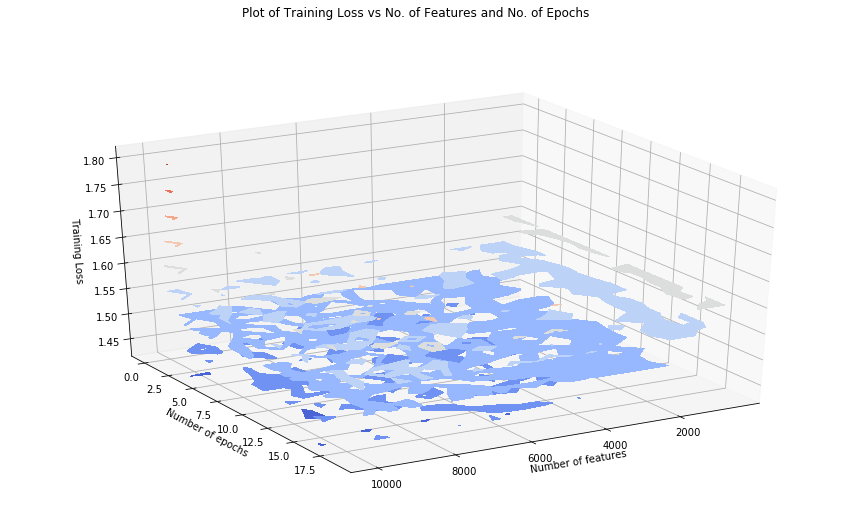

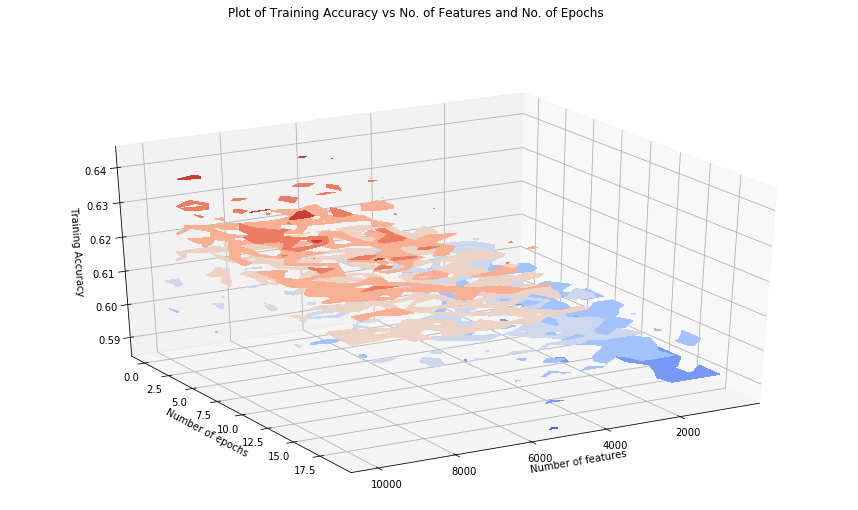

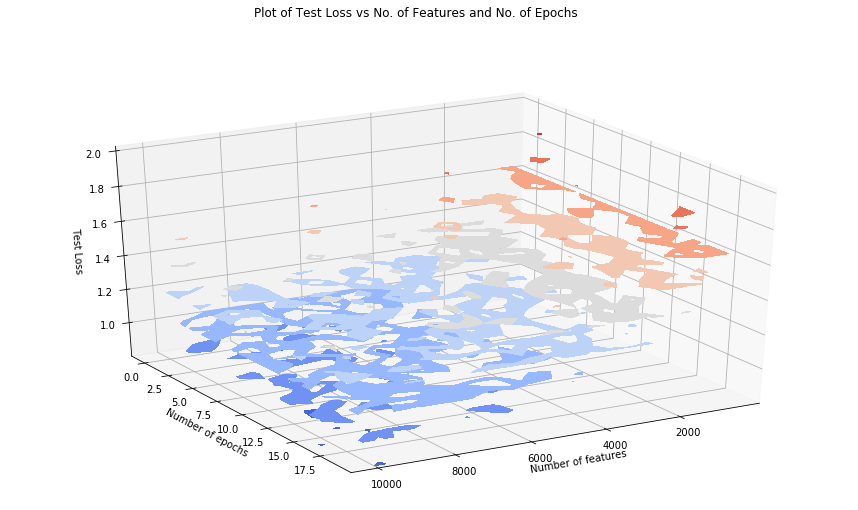

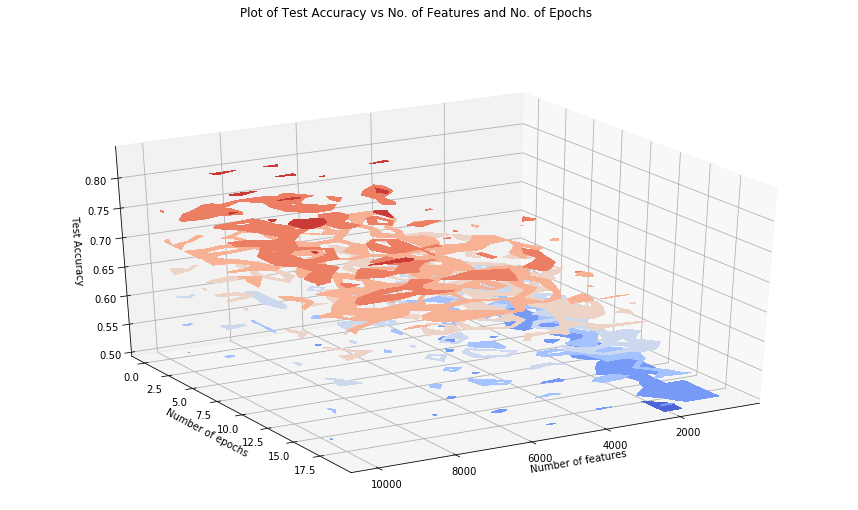

In [18]:
plt.rcParams['figure.figsize'] = (15, 8)

fx = np.arange(500,10500,500)
fy = np.arange(20)

print fx
#print(ts_acc)
fx, fy = np.meshgrid(fx, fy)
print fx.shape, fy.shape
#plt.subplot(221)
tr_loss = np.array(sd['tr_loss']).T
tr_acc = np.array(sd['tr_acc']).T
ts_loss = np.array(sd['ts_loss']).T
ts_acc = np.array(sd['ts_acc']).T

#print tr_loss
#print len(tr_loss[0])

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111, projection='3d')

fig4 = plt.figure()
ax4 = fig4.add_subplot(111, projection='3d')


ax1.contourf(fx, fy, tr_loss, label='Training Loss', cmap=cm.coolwarm)

ax2.contourf(fx, fy, tr_acc, label='Training accuracy', cmap=cm.coolwarm )

ax3.contourf(fx, fy, ts_loss, label='Test Loss', cmap=cm.coolwarm)

ax4.contourf(fx, fy, ts_acc, label='Test accuracy', cmap=cm.coolwarm)


ax1.set_xlabel("Number of features")
ax1.set_ylabel("Number of epochs")
ax1.set_zlabel("Training Loss")

ax2.set_xlabel("Number of features")
ax2.set_ylabel("Number of epochs")
ax2.set_zlabel("Training Accuracy")

ax3.set_xlabel("Number of features")
ax3.set_ylabel("Number of epochs")
ax3.set_zlabel("Test Loss")

ax4.set_xlabel("Number of features")
ax4.set_ylabel("Number of epochs")
ax4.set_zlabel("Test Accuracy")

fig1.suptitle("Plot of Training Loss vs No. of Features and No. of Epochs")
fig2.suptitle("Plot of Training Accuracy vs No. of Features and No. of Epochs")
fig3.suptitle("Plot of Test Loss vs No. of Features and No. of Epochs")
fig4.suptitle("Plot of Test Accuracy vs No. of Features and No. of Epochs")

ax1.view_init(30, 60)
ax2.view_init(30,60)
ax3.view_init(30, 60)
ax4.view_init(30,60)

plt.show()

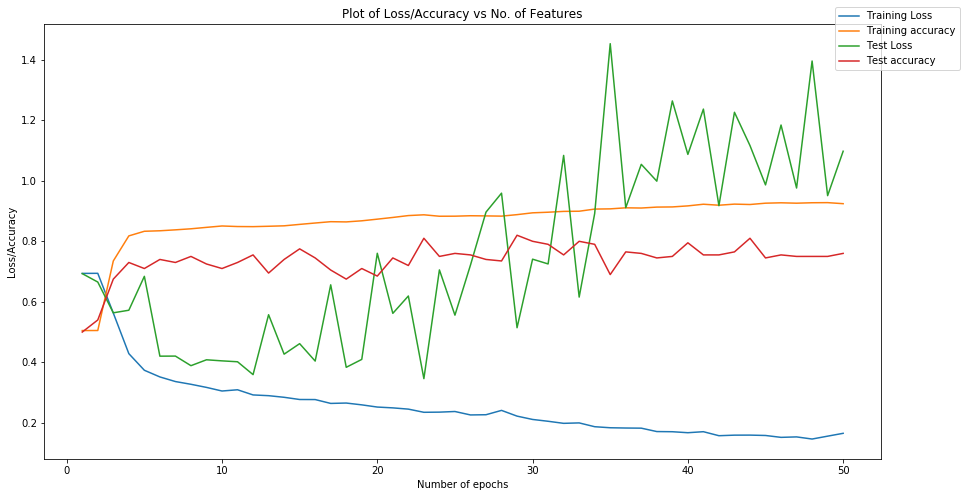

In [63]:
plt.rcParams['figure.figsize'] = (15, 8)

f = np.arange(1,51, 1)

#plt.subplot(221)
plt.plot(f, tr_loss, label='Training Loss')

#plt.subplot(222)
plt.plot(f, tr_acc, label='Training accuracy')

#plt.subplot(223)
plt.plot(f, ts_loss, label='Test Loss')

#plt.subplot(224)
plt.plot(f, ts_acc, label='Test accuracy')

plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.xlabel("Number of epochs")
plt.ylabel("Loss/Accuracy")
plt.title("Plot of Loss/Accuracy vs No. of Features")

plt.show()

In [60]:
h_ts = model.evaluate(X_ts, y_ts, batch_size=X_ts.shape[0])
l_ts = h_ts[0]
a_ts = h_ts[1]
print l_ts
print a_ts

200/200 [==============================] - 1s
0.626439442385
0.69


[[-1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  -1.  1.]
 [-1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.
   1. -1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.
  -1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
   1.  1.]
 [ 1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1.
   1. -1.]
 [ 1. -1.  1.  1. -1.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.
   1. -1.]
 [ 1. -1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.
  -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  0.  0.  0.  0.  0.
   0.  0.]
 [ 1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.

In [11]:
print y_ts[0:20]

[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


In [47]:
f_0_p = 'data/tbb/feat/0'
f_1_p = 'data/tbb/feat/1'
feats_0_list = []
for fil in os.listdir(f_0_p):
    feats = []
    with open(os.path.join(f_0_p, fil)) as f:
        feats = f.readlines()
        feats = [float(line) for line in feats]
    feats = np.array(feats)
    feats1 = np.zeros(4000)
    length = min(len(feats), 4000)
    feats1[:length] = feats[:length]
    #print len(feats)
    feats_0_list.append(feats1)

f1 = np.array(feats_0_list)
lab_1_tr = np.zeros((f1.shape[0],1))
lab_1_tr[:,0] = 1
f1 = f1.reshape(f1.shape[0], f1.shape[1], 1)

In [48]:
model = ConvNet(4000, 'model_4000_4400_500_True_32_10_True.h5')
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']  )

In [49]:
model.evaluate(f1, lab_1_tr, batch_size=32)

800/800 [==============================] - 3s     


[1.3309255066460104, 0.66249999999999998]

In [50]:
print f1

[[[-1.]
  [-1.]
  [-1.]
  ..., 
  [-1.]
  [ 1.]
  [ 1.]]

 [[-1.]
  [-1.]
  [-1.]
  ..., 
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ..., 
  [-1.]
  [-1.]
  [-1.]]

 ..., 
 [[-1.]
  [-1.]
  [-1.]
  ..., 
  [-1.]
  [-1.]
  [-1.]]

 [[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [-1.]
  [-1.]
  [-1.]]

 [[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [-1.]
  [-1.]
  [-1.]]]


In [108]:
def get_feats_multitab(feat_path, labels_path, max_feat_count):
    feats_0_list = []
    feats_1_list = []
    lab_dict = {}
    
    for fil in os.listdir(labels_path):
        labs_fil = []
        lines = []
        with open(os.path.join(labels_path, fil)) as f:
            lines = f.readlines()
        headers = lines[0].split(",")
        crawl_pattern=r"(.+)_labels\.csv"
	mch = re.match(crawl_pattern, fil)
	crawl = mch.group(1)
	dict_line = {}
        for i in xrange(1, len(lines)):
            fields = lines[i].split(",")
            batch = fields[0]
            site = fields[1]
            label = fields[3]
            keyname = "%s_%s_%s"%(crawl, batch, site)
            lab_dict[keyname] = label
	#print lab_dict["%s_0_google.com"%crawl]
	#print lab_dict["%s_1_google.com"%crawl]            
    print lab_dict        
    for fil in os.listdir(feat_path):
        feats = []
        with open(os.path.join(feat_path, fil)) as f:
            feats = f.readlines()
            feats = [float(line) for line in feats]    
        feats = np.array(feats)
        feats1 = np.zeros(max_feat_count)
        length = min(len(feats), max_feat_count)
        feats1[:length] = feats[:length]
        feats1 = feats1.tolist()
        #print len(feats)
        labels = []
        pattern = r"(crawl\d+_\d+)_\d+-([^_]+)_(\d)_.*\.feat"
        #Get label based on crawl name, batch number and main site name
        mch = re.match(pattern, fil)
        crawl = mch.group(1)
        site  = mch.group(2)
        batch = mch.group(3)
        keyname = "%s_%s_%s"%(crawl, batch, site)
        label = lab_dict[keyname]
        feats1.append(label)
        feats1 = np.array(feats1, dtype='float32')
        
        if int(label) == 0:
            feats_0_list.append(feats1)
        else:
            feats_1_list.append(feats1)
            
    return feats_0_list, feats_1_list  



In [ ]:
#feat_path="data/mta/feat/"
#labels_path="data/mta/labels/"
#max_feat_count=4000

#f0, f1 = get_feats_multitab(feat_path, labels_path, max_feat_count)
#print len(f0), len(f1)
def get_instances_multitab(feats_0_list, feats_1_list, max_feat_count, num_test):
    feats_0_list.append(feats_0_list[0:1000-len(feats_0_list)])
    feats_1_list.append(feats_1_list[0:1000-len(feats_1_list)])
    f0 = np.array(feats_0_list)
    f1 = np.array(feats_1_list)
    np.random.shuffle(f0)
    np.random.shuffle(f1)
    f0_tr = f0[:-num_test, :]; f0_ts = f0[-num_test:, :]
    f1_tr = f1[:-num_test, :]; f1_ts = f1[:num_test:, :]
    
    return f0_tr, f1_tr, f0_ts, f1_ts

In [ ]:
def get_shuffled_multitab(max_feat_count, f0_tr, f1_tr, f0_ts, f1_ts):
    return get_shuffled(max_feat_count, f0_tr, None, f1_tr, None, f0_ts, None, f1_ts, None)